In [1]:
import torch
%load_ext autoreload
import neptune.new as neptune
from trainers import timegan_generate_data, rtsgan_generator, rgan_generator
from utils import *

# Makes sure the same testset is generated every time
np.random.seed(42)
alpha = 0.7
noise = 0
testset = DatasetSinus(num=5000, seq_len=100, alpha=alpha, noise=noise)

sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]


In [4]:
data = testset[:][0]
data.size()

torch.Size([600, 100, 3])

In [ ]:
%autoreload
# Models
from architectures.timegan_cnn_DG import *
#from architectures.timegan_cnn_D import *
#from architectures.timegan_cnn_G import *
#from architectures.timegan_cnn_DGER import *
#from architectures.RGAN import *
#from architectures.RTSGAN import *

print(f"Loading architecture: {ID}")

In [ ]:
id = "TIMEGAN-178" # 84 RTSGAN-66
project_name = "timeGAN" # RTSGAN

#id = "RTSGAN-66"
#project_name = "RTSGAN"

run = neptune.init_run(
                with_id=id, # "TIMEGAN-84"
                project="kohmann/" + project_name,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
                   )
params = run["parameters"].fetch()
params["device"] = "cpu"
params["testset_size"] = len(testset)
#params["model_name"] = "model_checkpoint.pt"

if "TimeGAN" in ID:
    model = TimeGAN(params)
elif ID == "RGAN":
    model = RGAN(params)
elif ID == "RTSGAN":
    model = RTSGAN(params)
else:
    raise ValueError
model = restore_weights(model, run)


In [ ]:
%autoreload
np.random.seed(42)
#fake_data = rtsgan_generator(model, params, eval=True)
fake_data = timegan_generate_data(model, torch.tensor(testset.T), params["max_seq_len"], params["Z_dim"])

#### Evaluation methods

In [ ]:
run = neptune.init_run(
    project="kohmann/Evaluation",
    name=ID,
    description="",
    #source_files=["architectures/RTSGAN.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)
run["model_id"] = ID + "-" + id.split('-')[-1]

from metrics import compare_sin3_generation, sw_approx, prediction_score# sinkhorn_distance, MMD,
np.random.seed(42)
testset2 = DatasetSinus(num=1000, seq_len=100, alpha=alpha, noise=noise)
mse_error = compare_sin3_generation(fake_data, 0.7, 0)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data)
y = testset[:][0]
y_2 = testset2[:][0]
#wass_dist = sinkhorn_distance(x,y)
#mmd = MMD(x,y)
sw_baseline = sw_approx(y,y_2)
sw = sw_approx(y,x)

run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/sin3_generation_MSE_loss"] = mse_error
#run["numeric_results/wasserstein_distance_mean"] = wass_dist.mean()
#run["numeric_results/wasserstein_distance_std"] = wass_dist.std()
run["numeric_results/SW"] = sw.item()
run["numeric_results/SW_baseline"] = sw_baseline.item()

r = np.array([data[0].numpy() for data in testset])
#sin = None
#f_pca = visualization(r[:,:,sin][:,:,None], fake_data[:,:,sin][:,:,None], 'umap')
run["PCA"].upload(visualization(r, fake_data, 'pca'))
run["tSNE"].upload(visualization(r, fake_data, 'tsne'))
run["UMAP"].upload(visualization(r, fake_data, 'umap'))

from metrics import prediction_score

div = int(len(fake_data) * 0.8)
prediction_score(fake_data[:div], fake_data[div:], data, neptune_logger=run)

run.stop()

In [39]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import time
from metrics import compare_sin3_generation, sw_approx

## First sample from two different distributions
m1 = torch.tensor([1., 2., 3.])
m2 = torch.tensor([4., 5., 6.])
sig1 = torch.tensor([[1., 1., 1.], [1., 2., 2.], [1., 2., 3.]])
sig2 = torch.eye(3)
mu_distrib = MultivariateNormal(m1, sig1)
nu_distrib = MultivariateNormal(m2, sig2)

w_true = list()
w_est = list()

for e in range(2, 6):
    n = 10**e # number of samples
    mu_samples = mu_distrib.rsample(sample_shape=torch.Size([n]))
    nu_samples = nu_distrib.rsample(sample_shape=torch.Size([n]))

    # True Wasserstein
    w = torch.norm(m1 - m2, p=2) + torch.trace(sig1 + sig2 - 2*torch.sqrt(torch.sqrt(sig1) * sig2 * torch.sqrt(sig1)))
    w_true.append(w)
    # Approximation of the Sliced Wasserstein
    sw_ap = sw_approx(mu_samples, nu_samples)
    w_est.append(sw_ap)

    print(f"Approx SW : {sw_ap}: True SW: {w}- approx error {torch.abs(sw_ap - w)}")

sw(µ, µ): tensor(0.0692)
Approx SW : 5.549803256988525: True SW: 5.903623580932617- approx error 0.3538203239440918
sw(µ, µ): tensor(0.0027)
Approx SW : 5.668168067932129: True SW: 5.903623580932617- approx error 0.23545551300048828
sw(µ, µ): tensor(0.0001)
Approx SW : 5.540704250335693: True SW: 5.903623580932617- approx error 0.36291933059692383
sw(µ, µ): tensor(7.9431e-05)
Approx SW : 5.602689266204834: True SW: 5.903623580932617- approx error 0.3009343147277832


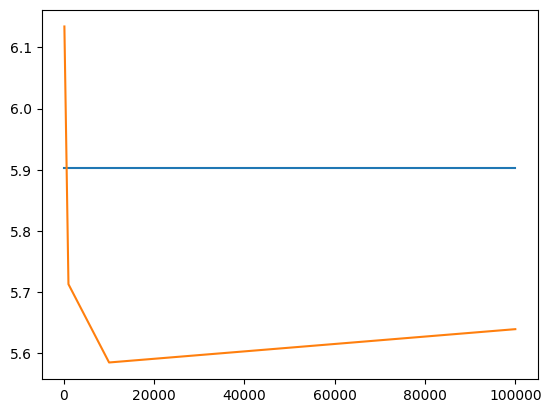

In [37]:
import matplotlib.pyplot as plt
plt.plot([10**e for e in range(2,6)], w_true)
plt.plot([10**e for e in range(2,6)], w_est)

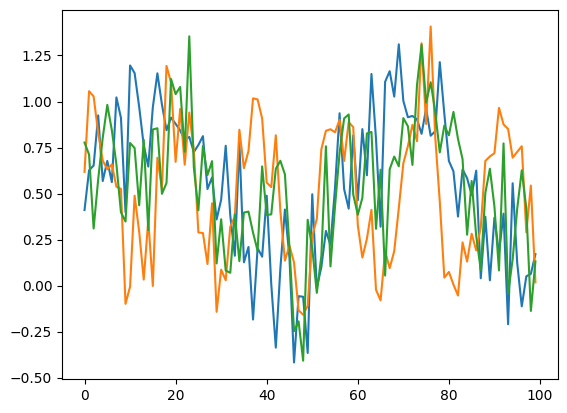

In [55]:
curves = testset[:][0][0]
plt.plot(curves + torch.randn_like(curves)*0.2)

In [39]:
 # Dynamic RNN input for ignoring paddings


In [42]:
%autoreload
from metrics import prediction_score
from utils import *
data = DatasetSinus(num=600, seq_len=100, alpha=alpha, noise=noise)[:][0]
prediction_score(data[:300], data[300:500], data[-100:], neptune_logger=None)

sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]



Epoch: 99, Train loss: 0.0027, Val loss: 0.0021: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


0.00019210742902942002